# Initial Test Data Analysis
See [This GitLAB Issue](https://code.crearecomputing.com/hearingproducts/open-hearing-group/open-hearing-hardware/-/issues/1) for details ont he data collection. 

In this notebook:

0. Load Common Data Structure (Setup)
1. Calibration
2. Validation


# 0. Load Common Data Structures

In [1]:
%matplotlib inline

## Imports

In [2]:
# Import dependencies
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, ndimage, optimize, interpolate
import scipy.io as spio

from owai.core import io
from owai.core import signal_processing_utils as spu
from owai.core.model import StraightTube, TwoDiameterTube
from owai.core.units import units

## Helper utillity functions

In [3]:
def get_meta_value_units(section, *keys):
    """ REquires test_meta and units to be global variables"""
    section = test_meta[section]
    root = section
    for key in keys:
        root = root.get(key)
    return root["value"] * units(root["units"])

def get_ptheory(f, x, model, **kwargs):
    for k, v in kwargs.items():
        setattr(model, k, v)
    return model.p(f, x)

def todB(a):
    return 20 * np.log10(np.abs(a) / 20e-6)

## File Paths and Metadata Loading

In [4]:
# Figure style and line style
figkwargs = dict(figsize=(6.5, 6.5 / 1.618034), dpi=90)
linekwargs = dict(lw=1, alpha=0.5)

# Set up path to the data
data_folder = "2024-07-01_AurenV1_calibration-data-collection"
# data_folder = "2024-07-24_AurenV1_calibration"
path = os.path.join("Olympus", "Projects", "1010564-OPEN-HEARING", "Technical Work", "Testing", "Data", data_folder)  # From windows
if os.environ.get("OLYMPUS_PROJECTS_PATH", False):
    path = path.replace(os.path.join('Olympus', "Projects"), os.environ.get("OLYMPUS_PROJECTS_PATH"))
print("Looking for data in this path:", path)

path_meta = os.path.join(path, 'testdata.yaml')
print("Looking for test meta data in this path:", path_meta)

# Load test metadata
test_meta = io.load_test_data(path_meta)
# pprint(test_meta)

# Set constants
speed_of_sound = 343 * units.m / units.s
n_channels = 4

# probe geometry
length_probe = get_meta_value_units("probe_geometry", "length")
length_tests = [length_probe + get_meta_value_units("test_geometry", "cavern_" + str(i + 1), "length") for i in range(4)]
x_probe = [
    length_probe + get_meta_value_units("test_geometry", "cavern_" + str(i + 1), "x_of_probe")
    for i in range(4)
    ]
x_mic = get_meta_value_units('probe_geometry', 'mic_positions')

# Dictionary to hold the calibration data
calibration_data = {"RL": 0.999, "R0": 0.999}  # We will store the calibration data here

Looking for data in this path: /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-07-01_AurenV1_calibration-data-collection
Looking for test meta data in this path: /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-07-01_AurenV1_calibration-data-collection/testdata.yaml


## Data loading

In [5]:
test_keys = [
    'cavern_1_B&K_in_probe_port',
    'cavern_2_B&K_in_probe_port',
    'cavern_3_B&K_in_probe_port',
    'cavern_4_B&K_in_probe_port',
    ]

# make sure all the data has the same shape
fn = os.path.join(path, test_meta["test_metadata"][test_keys[0]]["files"][0][0])
_, _, samplerate = io.load_wav(fn)
duration = test_meta["chirp_parameters"]["end_time"]["value"] - test_meta["chirp_parameters"]["start_time"]["value"]
data_slice = slice(
    int(test_meta["chirp_parameters"]["start_time"]["value"] * samplerate),
    int(test_meta["chirp_parameters"]["end_time"]["value"] * samplerate), None)

times = {}
data = {}
times_ref = {}
data_ref = {}
for i, test_key in enumerate(test_keys):
    cavern_times = []
    cavern_data = []
    cavern_times_ref = []
    cavern_data_ref = []
    for j, tests in enumerate(test_meta["test_metadata"][test_key]["files"]):
        fn = os.path.join(path, tests[0])
        t, d, samplerate = io.load_wav(fn, )
        cavern_times.append(t[data_slice])
        cavern_data.append(d[data_slice].T)
        if len(tests) == 1:
            continue
        fn = os.path.join(path, tests[1])
        t, d, samplerate_bk = io.load_wav(fn)
        slc = spu.trim_signal_sharp_jump(d, samplerate_bk, duration=5, kernel_size=65, end=True, return_index=True)
        cavern_times_ref.append(t[slc])
        cavern_data_ref.append(d[slc].T)
    times[test_key] = cavern_times
    data[test_key] = cavern_data
    times_ref[test_key] = cavern_times_ref
    data_ref[test_key] = cavern_data_ref
# Done reading all the data

Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Using scaling data from  /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-07-01_AurenV1_calibration-data-collection/BKProbe_003.dat
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Using scaling data from  /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-07-01

## Fourier Transforms and Data Wrangling

In [6]:
# Use last two tests
f_ref = []
p_ref = []
p = []
f = []
for key in test_keys:
    this_p_ref = []
    this_f_ref = []
    this_p = []
    this_f = []
    for test in [-2, -1]:
        my_f, my_p = spu.to_fourier(data[key][test], samplerate)
        keep_inds = (my_f >= 100) & (my_f < 20000)
        my_f = my_f[keep_inds]
        my_p = my_p[:, keep_inds]
        this_p.append(my_p)
        this_f.append(my_f)
        if not data_ref[key]:
            continue
        my_f_ref, my_p_ref = spu.to_fourier(data_ref[key][test], samplerate_bk)
        keep_inds = (my_f_ref >= 100) & (my_f_ref < 20000)
        my_f_ref = my_f_ref[keep_inds]
        my_p_ref = my_p_ref[keep_inds]
        this_p_ref.append(my_p_ref)
        this_f_ref.append(my_f_ref)

    this_p = np.stack(this_p, axis=0)
    this_f = np.stack(this_f, axis=0)
    p.append(this_p)
    f.append(this_f)
    if not this_p_ref:
        continue
    this_p_ref = np.stack(this_p_ref, axis=0)
    this_f_ref = np.stack(this_f_ref, axis=0)
    p_ref.append(this_p_ref)
    f_ref.append(this_f_ref)
p = np.stack(p, axis=0)
f = np.stack(f, axis=0)
p_ref = np.stack(p_ref, axis=0)
f_ref = np.stack(f_ref, axis=0)
axis_order = ['test_geometry', 'test_iteration', "channel", 'data']

In [7]:
R0 = calibration_data["R0"]
RL = calibration_data["RL"]
cavern_model = StraightTube(L=0, R0=R0, RL=RL, P0=1.0, PL=0.0)

# First, we need to try an align the theory with the measurements

In [8]:
20 * np.log10(np.abs(p_ref) / 20e-6).max()  # Scaling looks pretty good

56.0223571738338

### Plots

Cavern 0, Trial 0, Magdiff 0.019325255114474537
Cavern 0, Trial 1, Magdiff 0.3007256235866677
Cavern 1, Trial 0, Magdiff 0.018546543140250588
Cavern 1, Trial 1, Magdiff 0.018557830900817834
Cavern 2, Trial 0, Magdiff 0.01858697146192767
Cavern 2, Trial 1, Magdiff 0.018634684846235844
Cavern 3, Trial 0, Magdiff 0.020130735651715914
Cavern 3, Trial 1, Magdiff 0.020142959354646772


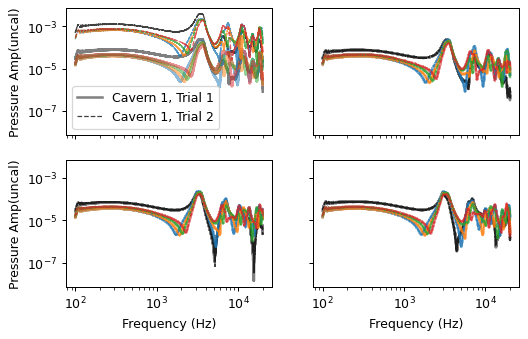

In [9]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)
ref_channel = 3
lines = ['-', '--']
for i in range(4):
    ii = i // 2
    jj = i % 2
    for j in range(2):
        magdiff = np.abs(p[i, j, ref_channel, :]).mean() / np.abs(p_ref[i, j, :]).mean()
        axs[ii,jj].loglog(f_ref[i, j], np.abs(p_ref[i, j, :]) * magdiff, 'k' + lines[j], label="Cavern {}, Trial {}".format(i+1,j+1), lw=2-j, alpha=0.5 + 0.25 * j)
        if i == 0: axs[ii,jj].legend()
        print ("Cavern {}, Trial {}, Magdiff {}".format(i, j, magdiff))
    for j in range(2):
        axs[ii,jj].set_prop_cycle(None)
        axs[ii,jj].loglog(f[i, j], np.abs(p[i, j, :, :]).T, lines[j], label="Trial {}".format(j + 1), lw=2-j, alpha=0.5 + 0.25 * j)
axs[-1, 0].set_xlabel('Frequency (Hz)')
axs[-1, 1].set_xlabel('Frequency (Hz)')
axs[0, 0].set_ylabel('Pressure Amp(uncal)')
axs[-1, 0].set_ylabel('Pressure Amp(uncal)')
plt.show()

# 1. Calibration

In [10]:
p_ref_on_f = np.array([[np.interp(f[i, j], f_ref[i, j], np.abs(p_ref[i, j])) for j in range(p_ref.shape[1])] for i in range(p_ref.shape[0])])

In [11]:
# cavern_model.absorption_loss = 0.4
# cavern_model.absorption_loss = 0.2
# cavern_model.absorption_loss = 0.1
# cavern_model.absorption_loss = 0.05
# cavern_model.absorption_loss = 0.005
# cavern_model.absorption_loss = 0.01
# cavern_model.absorption_loss = 0.08
# cavern_model.absorption_loss = 0.04
cavern_model.absorption_loss = 0.0

To solve for the calibrations, we use the following set of equations for EACH cavern:
\begin{align}
    A_0 e^{-ijkL_0} + B_0 e^{ijkL_0} - p_0 p_{cal,0} &=0\\
    A_0 e^{-ijkL_1} + B_0 e^{ijkL_1} - p_1 p_{cal,1}  &=0\\
    A_0 e^{-ijkL_{ref}} + B_0 e^{ijkL_{ref}} = p_{ref} \\
\end{align}

As a matrix, that looks like this: 
\begin{gather}
    \begin{bmatrix} 
        e^{-ijkL_0} &      e^{ijkL_0}     & -p_0  & 0 \\
        e^{-ijkL_1} &      e^{ijkL_1}     &  0    &-p_1\\
        e^{-ijkL_{ref}} &  e^{ijkL_{ref}} & 0 & 0
    \end{bmatrix}
    \begin{bmatrix}
        A_0 \\
        B_0 \\
        p_{cal,0} \\
        p_{cal,1}
    \end{bmatrix}
        =
    \begin{bmatrix}
        0 \\
        0 \\
        p_{ref} 
    \end{bmatrix}
\end{gather}

We don't have enough equations (3 equations, 4 unknowns), so we have to add additional caverns... then it becomes like this: 
\begin{gather}
    \begin{bmatrix} 
        e^{-ijkL_0} & e^{ijkL_0} & 0 & 0 & -p_0  & 0 \\
        e^{-ijkL_1} & e^{ijkL_1} & 0 & 0 & 0 & -p_1\\
        e^{-ijkL_{ref}} &  e^{ijkL_{ref}} & 0 & 0 & 0 & 0 \\
        0 & 0 & e^{-ijkL_0} & e^{ijkL_0} & -p_0  & 0 \\
        0 & 0 & e^{-ijkL_1} & e^{ijkL_1} &  0    &-p_1\\
        0& 0 & e^{-ijkL_{ref}} &  e^{ijkL_{ref}} & 0 & 0  \\
    \end{bmatrix}
    \begin{bmatrix}
        A_{0} \\
        B_{0} \\
        A_{1} \\
        B_{1} \\
        p_{cal,0} \\
        p_{cal,1}
    \end{bmatrix}
        =
    \begin{bmatrix}
        0 \\
        0 \\
        0 \\
        0 \\
        p_{ref, 0} \\
        p_{ref, 1} 
    \end{bmatrix}
\end{gather}

But ultimately, we only care about the last two unknowns in x. 




In [12]:
channels = [0, 1, 2, 3]  # NOTE: The reference channel is the last one listed (channels[-1])
channels = [1, 2, 3]  # NOTE: The reference channel is the last one listed (channels[-1])
n_channels = len(channels)
n_caverns = 4
trial_number = 0
x = x_mic[channels].to('m').magnitude
# x[2] -= 0.002 # See what an offset does
# x[0] += 0.002 # See what an offset does

k = cavern_model.k(f[0, 0]).magnitude
A = np.zeros((p.shape[-1], n_channels * n_caverns, 2 * n_caverns + n_channels-1), dtype=np.complex128)
b = np.zeros((p.shape[-1], n_channels * n_caverns), dtype=np.complex128)
for j in range(n_caverns):
    A[:, j*n_channels:(j+1) * n_channels, j*2 + 0] = np.exp(-1j * k[:, None] * x[None, :])
    A[:, j*n_channels:(j+1) * n_channels, j*2 + 1] = np.exp( 1j * k[:, None] * x[None, :])
    for i in range(n_channels - 1):
        A[:, j*n_channels + i, -n_channels + 1 + i] = -p[j, trial_number, channels[i]]
        # A[:, j*n_channels + 1, -1] = -p[j, 0, channels[1]]
    b[:, j*n_channels + n_channels - 1] = p[j, 0, channels[-1]]

Ainv = np.linalg.pinv(A)
cal = np.einsum('ijk,ik->ij', Ainv, b)

In [13]:
# Re-arrange the calibration function so that it goes channel 0, channel 1, ... etc. 
# The first of these is not actually a calibration, we'll use it for the reference channel
cal_ordered = np.empty((p.shape[-1], p.shape[-2]), cal.dtype)
cal_ordered.fill(1)
# Set reference channel calibration to all 1's
cal_ordered[:, channels[-1]] = 1
# Collect channel calibration data
cal_ordered[:, channels[:-1]] = cal[:, -n_channels + 1:]

### CAB approach
To solve for the calibrations, we use the following set of equations for EACH cavern:
\begin{align}
    A_0 e^{-ijkL_0} + B_0 e^{ijkL_0} - p_0 p_{cal,0} &=0\\
    A_0 e^{-ijkL_1} + B_0 e^{ijkL_1} - p_1 p_{cal,1}  &=0\\
    A_0 e^{-ijkL_{ref}} + B_0 e^{ijkL_{ref}} - p_2 p_{cal,2} &= 0
\end{align}

As a matrix, that looks like this: 
\begin{gather}
    \begin{bmatrix} 
        e^{-ijkL_0} &      e^{ijkL_0}     & -p_0  & 0 & 0\\
        e^{-ijkL_1} &      e^{ijkL_1}     &  0    &-p_1 & 0\\
        e^{-ijkL_{ref}} &  e^{ijkL_{ref}} & 0 & 0 & -p_2
    \end{bmatrix}
    \begin{bmatrix}
        A_0 \\
        B_0 \\
        p_{cal,0} \\
        p_{cal,1} \\
        p_{cal,2} 
    \end{bmatrix}
        =
    \begin{bmatrix}
        0 \\
        0 \\
        0
    \end{bmatrix}
\end{gather}

We don't have enough equations (3 equations, 4 unknowns), so we have to add additional caverns... then it becomes like this: 
\begin{gather}
    \begin{bmatrix} 
        e^{-ijkL_0} & e^{ijkL_0} & 0 & 0 & -p_0  & 0 & 0\\
        e^{-ijkL_1} & e^{ijkL_1} & 0 & 0 & 0 & -p_1  & 0 \\
        e^{-ijkL_{ref}} &  e^{ijkL_{ref}} & 0 & 0 & 0 & 0 & -p_2 \\
        0 & 0 & e^{-ijkL_0} & e^{ijkL_0} & -p_0  & 0  & 0 \\
        0 & 0 & e^{-ijkL_1} & e^{ijkL_1} &  0    &-p_1 & 0 \\
        0& 0 & e^{-ijkL_{ref}} &  e^{ijkL_{ref}} & 0 & 0 & -p_2 \\
    \end{bmatrix}
    \begin{bmatrix}
        A_{0} \\
        B_{0} \\
        A_{1} \\
        B_{1} \\
        p_{cal,0} \\
        p_{cal,1} \\
        p_{cal,2}
    \end{bmatrix}
        =
    \begin{bmatrix}
        0 \\
        0 \\
        0 \\
        0 \\
        0 \\
        0 \\
        0
    \end{bmatrix}
\end{gather}

But ultimately, we only care about the last three unknowns in x. 




In [14]:
# channels = [0, 1, 2, 3]  
channels = [1, 2, 3]  
# channels = [1, 3]  # This doesn't work -- always 1 channel short
n_channels = len(channels)
n_caverns = 4
trial_number = 0
x = x_mic[channels].to('m').magnitude
# x[2] -= 0.002 # See what an offset does
# x[0] += 0.002 # See what an offset does

k = cavern_model.k(f[0, 0]).magnitude
A = np.zeros((p.shape[-1], n_channels * n_caverns, 2 * n_caverns + n_channels), dtype=np.complex128)
b = np.zeros((p.shape[-1], n_channels * n_caverns), dtype=np.complex128)
for j in range(n_caverns):
    A[:, j*n_channels:(j+1) * n_channels, j*2 + 0] = np.exp(-1j * k[:, None] * x[None, :])
    A[:, j*n_channels:(j+1) * n_channels, j*2 + 1] = np.exp( 1j * k[:, None] * x[None, :])
    for i in range(n_channels):
        A[:, j*n_channels + i, -n_channels + i] = -p[j, trial_number, channels[i]]
        # A[:, j*n_channels + 1, -1] = -p[j, 0, channels[1]]
    # b[:, j*n_channels + n_channels - 1] = p[j, 0, channels[-1]]

# A = u @ np.diag(s) @ vh = 0  Ax = lambda x -- solve for x
u,s,vh = np.linalg.svd(A)
cal_cab = vh[:, -1, :]
# cal_cab = vh[:, :, -1]  # Wrong order because vh is hermetian transpose
cal_cab = vh[:, -1, :].conjugate()  # Maybe taking conjugate is important?

In [15]:
# Sanity check: 
np.abs((A[0] @ cal_cab[0])), s[0, -1]

(array([1.17777755e-08, 2.26490477e-08, 1.08718057e-08, 2.54726579e-08,
        4.89847569e-08, 2.35132529e-08, 1.91118956e-08, 3.67528019e-08,
        1.76417719e-08, 7.99274806e-09, 1.53703159e-08, 7.37792997e-09]),
 8.217637654200112e-08)

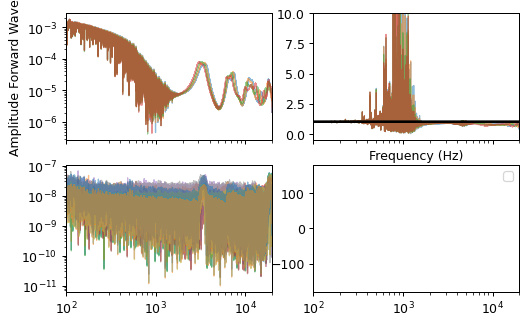

In [16]:
# More sanity checks
sol = np.einsum('ijk,ik->ij', A, cal_cab)
A0 = cal_cab[:, 0:n_caverns * 2:2]
B0 = cal_cab[:, 1:n_caverns * 2:2]
R =  B0 / A0

fig, axs = plt.subplots(2, 2, sharex=True, **figkwargs)
# plt.loglog(f[0, 0], np.abs(sol[:, :n_caverns*2:2]), alpha=0.5, lw=1)
axs[0, 0].loglog(f[0, 0], np.abs(A0), alpha=0.5, lw=1)
axs[1, 0].loglog(f[0, 0], np.abs(sol), alpha=0.5, lw=1)
axs[0, 1].semilogx(f[0, 0], np.abs(R), alpha=0.5, lw=1)
axs[0, 1].semilogx(f[0, 0], np.abs(R) * 0 + 1, 'k')
# axs[1, 1].semilogx(f[0, 0], np.rad2deg(np.angle(sol)), alpha=0.5, lw=1)
# plt.ylim(1,500)
axs[0, 0].set_ylabel("Amplitude Forward Wave")
axs[0, 1].set_xlabel("Frequency (Hz)")
axs[0, 0].set_xlim(100, 20000)
axs[0, 1].set_ylim(-0.5, 10)
axs[1, 1].set_ylim(-180, 180)
# axs[1, 0].set_ylim(-180, 180)
plt.legend(range(n_caverns))


In [17]:
# Re-arrange the calibration function so that it goes channel 0, channel 1, ... etc. 
# The first of these is not actually a calibration, we'll use it for the reference channel
cal_ordered_cab = np.ones((p.shape[-1], p.shape[-2]), cal.dtype)
# Collect channel calibration data
cal_ordered_cab[:, channels] = cal_cab[:, -n_channels:]

# subtract out the reference channel Phase
ref = 3
cal_ordered_cab[:, channels] /= (cal_ordered_cab[:, ref:ref+1] * np.abs(cal_ordered_cab[:, ref:ref+1]))
# cal_ordered_cab /= (cal_cab[:, -1:])# * np.abs(cal_cab[:, -1:]))


(-18.0, 18.0)

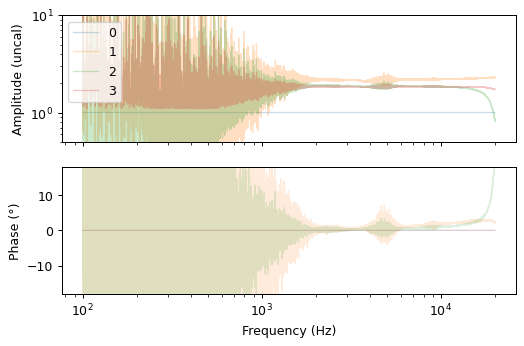

In [18]:
fig, axs = plt.subplots(2, 1, sharex=True, **figkwargs)
axs[0].loglog(f[0, 0], np.abs(cal_ordered_cab), lw=1, alpha=0.25)
axs[0].legend(range(4))
# axs[0].set_prop_cycle(None)
# axs[0].loglog(f[0, 0], np.abs(cal2[:, :-1]), lw=3)
# axs[0].loglog(f[0, 0], cal_amp[:-1].T, 'k', lw=1)
axs[0].set_ylabel("Amplitude (uncal)")
axs[0].set_ylim([0.5, 10])
axs[1].semilogx(f[0, 0], np.rad2deg(np.angle(cal_ordered_cab)), lw=1, alpha=0.15)
# axs[1].set_prop_cycle(None)
# axs[1].semilogx(f[0, 0], np.rad2deg(np.angle(cal2[:, :-1])), lw=3)
# axs[1].semilogx(f[0, 0], np.rad2deg(cal_phase[:-1].T),'k')
axs[1].set_ylabel('Phase (°)')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylim([-18, 18])

In [19]:
cal_ordered = cal_ordered_cab

In [20]:
if False:
    s_phase = 0.01
    s_amp = 0.0025
    
    # s_phase = 0.1
    # s_amp = 0.025
    
    s_phase = 0.0025
    s_amp = 0.0025
    
    s_phase = 0.0025
    s_amp = 0.25
    
    
    cal_phase = [interpolate.splrep(
        (f[0, 0]), np.angle(cal_ordered[:, i]),w=np.sqrt(f[0, 0] / f[0, 0].max()),
        s=s_phase*f.shape[-1]) for i in range(p.shape[-2])]
    cal_amp = [interpolate.splrep(
        np.log10(f[0, 0]), np.log10(np.abs(cal_ordered[:, i])), #w=1/f[0, 0],
        s=s_amp*f.shape[-1]) for i in range(p.shape[-2])]
    cal_phase = np.stack([interpolate.splev((f[0, 0]), cal_phase[i]) for i in range(p.shape[-2])], axis=0)
    cal_amp = np.stack([10**interpolate.splev(np.log10(f[0, 0]), cal_amp[i]) for i in range(p.shape[-2])], axis=0)
    cal2 = (cal_amp * np.exp(1j*cal_phase)).T

In [21]:
# Heuristic smoothing
phase = np.angle(cal_ordered)
amp = np.abs(cal_ordered)

N = 1024
f_bins = np.logspace(np.log10(100), np.log10(20000), N)
f_center = (f_bins[1:] + f_bins[:-1]) / 2
# average phase and amplitude into these bins
cal_phase_bin = np.zeros((N-1, cal_ordered.shape[1]))
cal_amp_bin = np.zeros((N-1, cal_ordered.shape[1]))
for i in range(f_center.size):
    I = (f[0, 0] >= f_bins[i]) & (f[0, 0] < f_bins[i + 1])
    cal_phase_bin[i] = np.mean(phase[I], axis=0)
    cal_amp_bin[i] = np.mean(amp[I], axis=0)

# Just accept fate... and realize that phase below 1kHz is too noisy to calibrate
cal_phase_bin[f_center <= 1000] = 0
cal_amp_bin[f_center <= 1000] = cal_amp_bin[f_center > 1000][0]

# Smooth the results
sigma = 9
cal_phase_bin = ndimage.gaussian_filter1d(cal_phase_bin, sigma, mode="nearest", axis=0, truncate=2.5)
cal_amp_bin = ndimage.gaussian_filter1d(cal_amp_bin, sigma, mode="nearest", axis=0, truncate=2.5)

cal_phase = np.zeros(cal_ordered.shape).T
cal_amp = np.zeros(cal_ordered.shape).T
for i in range(cal_ordered.shape[1]):
    cal_phase[i] = np.interp(f[0, 0], f_center, cal_phase_bin[:, i])
    cal_amp[i] = np.interp(f[0, 0], f_center, cal_amp_bin[:, i])

cal2 = (cal_amp * np.exp(1j*cal_phase)).T


(-18.0, 18.0)

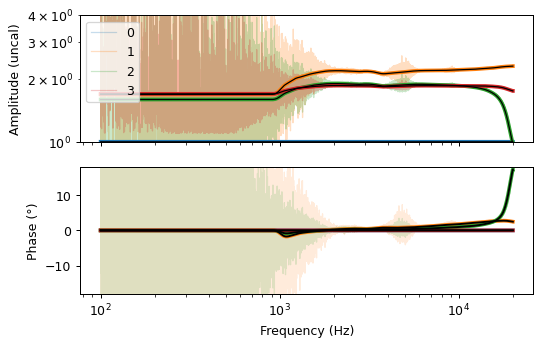

In [22]:
plt.close('all')
fig, axs = plt.subplots(2, 1, sharex=True, **figkwargs)
axs[0].loglog(f[0, 0], np.abs(cal_ordered), lw=1, alpha=0.25)
axs[0].legend(range(4))
axs[0].set_prop_cycle(None)
axs[0].loglog(f[0, 0], np.abs(cal2), lw=3)
axs[0].loglog(f[0, 0], cal_amp.T, 'k', lw=1)
axs[0].set_ylabel("Amplitude (uncal)")
axs[0].set_ylim([1, 4])
axs[1].semilogx(f[0, 0], np.rad2deg(np.angle(cal_ordered)), lw=1, alpha=0.15)
axs[1].set_prop_cycle(None)
axs[1].semilogx(f[0, 0], np.rad2deg(np.angle(cal2)), lw=3)
axs[1].semilogx(f[0, 0], np.rad2deg(cal_phase.T),'k')
axs[1].set_ylabel('Phase (°)')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylim([-18, 18])

/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Text(0.5, 0, 'Frequency (Hz)')

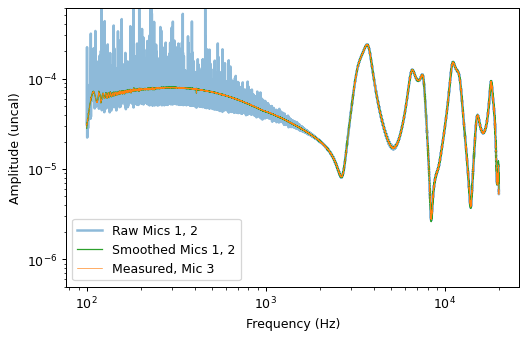

In [23]:
mic1 = 1
mic2 = 2
mic_ref = 3
channel = 0
trial = 0
p3_pred = cavern_model.p_measured(
    f[0, 0] * units.Hz,
    x_mic[mic_ref],
    x_mic[mic1], x_mic[mic2],
    p[channel, trial, mic1] * cal_ordered[:, mic1], p[channel, trial, mic2] * cal_ordered[:, mic2])
# mic1 = 1
p3_pred_smooth = cavern_model.p_measured(
    f[0, 0] * units.Hz,
    x_mic[mic_ref],
    x_mic[mic1], x_mic[mic2],
    p[channel, trial, mic1] * cal2[:, mic1], p[channel, trial, mic2] * cal2[:, mic2])

fig, axs = plt.subplots(1, 1, sharex=True, **figkwargs)
axs.loglog(f[0, 0], np.abs(p3_pred), 'C0', lw=2, alpha=0.5, label="Raw Mics %s, %s" % (mic1, mic2))
axs.loglog(f[0, 0], np.abs(p3_pred_smooth), 'C2', lw=1, label="Smoothed Mics %s, %s" % (mic1, mic2))
axs.loglog(f[0, 0], np.abs(p[channel, trial, mic_ref] * cal2[:, mic_ref]), 'C1', lw=0.5, label="Measured, Mic %d" % mic_ref)
axs.legend()
plt.ylim(5e-7, 6e-4)
axs.set_ylabel("Amplitude (uncal)")
axs.set_xlabel('Frequency (Hz)')

## Absolute amplitude calibration

To solve for the calibrations, we use the following set of equations for EACH cavern:
\begin{align}
    A_0 e^{-ijkL_0} + B_0 e^{ijkL_0} - p_0 p_{cal} &=0\\
    A_0 e^{-ijkL_1} + B_0 e^{ijkL_1} - p_1 p_{cal}  &=0\\
    A_0 e^{-ijkL_{probe}} + B_0 e^{ijkL_{probe}} = p_{probe} \\
\end{align}

As a matrix, that looks like this: 
\begin{gather}
    \begin{bmatrix} 
        e^{-ijkL_0} &      e^{ijkL_0}     & -p_0 \\
        e^{-ijkL_1} &      e^{ijkL_1}     & -p_1\\
        e^{-ijkL_{probe}} &  e^{ijkL_{probe}} & 0
    \end{bmatrix}
    \begin{bmatrix}
        A_0 \\
        B_0 \\
        p_{cal} \\
    \end{bmatrix}
        =
    \begin{bmatrix}
        0 \\
        0 \\
        p_{probe} 
    \end{bmatrix}
\end{gather}

We have enough equations (3 equations, 3 unknowns), but we have additional caverns... then it becomes like this: 
\begin{gather}
    \begin{bmatrix} 
        e^{-ijkL_0} & e^{ijkL_0} & 0 & 0 & -p_{0,0}  \\
        e^{-ijkL_1} & e^{ijkL_1} & 0 & 0 & -p_{1,0}\\
        e^{-ijkL_{probe}} &  e^{ijkL_{probe}} & 0 & 0 & 0  \\
        0 & 0 & e^{-ijkL_0} & e^{ijkL_0} & -p_{0,1} \\
        0 & 0 & e^{-ijkL_1} & e^{ijkL_1} & -p_{1,1}\\
        0& 0 & e^{-ijkL_{probe}} &  e^{ijkL_{probe}} & 0  \\
    \end{bmatrix}
    \begin{bmatrix}
        A_{0} \\
        B_{0} \\
        A_{1} \\
        B_{1} \\
        p_{cal} \\
    \end{bmatrix}
        =
    \begin{bmatrix}
        0 \\
        0 \\
        p_{probe, 0} \\
        0 \\
        0 \\
        p_{probe, 1} 
    \end{bmatrix}
\end{gather}

We care about the last unknown to finish the mic calibration, but we also use "A" for the speaker calibration. 



In [24]:
# channels = [0, 1, 2, 3]  # NOTE: The reference channel is the last one listed (channels[-1])
channels = [1, 2, 3]  # NOTE: The reference channel is the last one listed (channels[-1])
# channels = [1, 3]  # NOTE: The reference channel is the last one listed (channels[-1])
n_channels = len(channels)
n_caverns = 4
trial_number = 0
x = np.concatenate([x_mic[channels].to('m').magnitude, x_probe[0].to('m').magnitude])
n_x = x.size

# x[2] -= 0.002 # See what an offset does
# x[0] += 0.002 # See what an offset does

k = cavern_model.k(f[0, 0]).magnitude
A = np.zeros((p.shape[-1], (n_x) * n_caverns, 2 * n_caverns + 1), dtype=np.complex128)
b = np.zeros((p.shape[-1], (n_x) * n_caverns), dtype=np.complex128)
for j in range(n_caverns):
    A[:, j*n_x:(j+1) * n_x, j*2 + 0] = np.exp(-1j * k[:, None] * x[None, :])
    A[:, j*n_x:(j+1) * n_x, j*2 + 1] = np.exp( 1j * k[:, None] * x[None, :])
    for i in range(n_channels):
        A[:, j*n_x + i, -1] = -p[j, trial_number, channels[i]] * cal2[:, channels[i]]
        # A[:, jn_x -1] = -p[j, 0, channels[1]]
    b[:, (j + 1) * n_x - 1] = p_ref_on_f[j, trial_number]

Ainv = np.linalg.pinv(A)

sol = np.einsum('ijk,ik->ij', Ainv, b)
# amp_cal2 = (sol[:, -1])
amp_cal = np.abs(sol[:, -1])

In [25]:
# A.shape
# plt.spy(A[0])

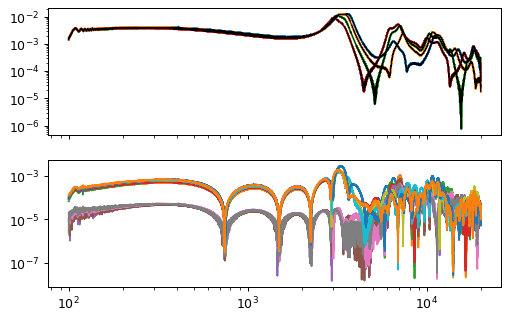

In [26]:
# Sanity check
b2 = np.einsum('ijk,ik->ij', A, sol)
fig, axs = plt.subplots(2,1,sharex=True, **figkwargs)
axs[0].loglog(f[0, 0], np.abs(b[:, (n_channels)::(n_channels + 1)]))
axs[0].loglog(f[0, 0], np.abs(p_ref_on_f[:, 0].T),'k', lw=0.5)
for i in range(n_channels):
    axs[1].loglog(f[0, 0], np.abs(b2[:, i::(n_channels + 1)]))

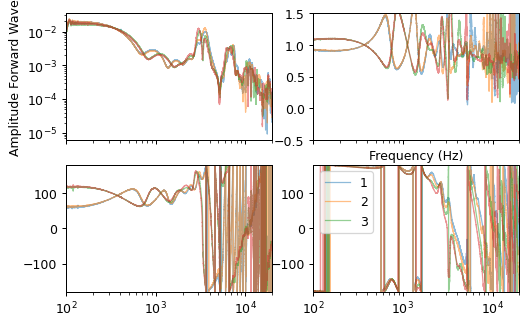

In [27]:
fig, axs = plt.subplots(2, 2, sharex=True, **figkwargs)
# plt.loglog(f[0, 0], np.abs(sol[:, :n_caverns*2:2]), alpha=0.5, lw=1)
axs[0, 0].loglog(f[0, 0], np.abs(sol[:, :n_caverns*2:2]), alpha=0.5, lw=1)
axs[1, 0].semilogx(f[0, 0], np.rad2deg(np.angle(sol[:, :n_caverns*2:2])), alpha=0.5, lw=1)
axs[0, 1].semilogx(f[0, 0], np.abs(sol[:, 1:n_caverns*2:2] / sol[:, :n_caverns*2:2]), alpha=0.5, lw=1)
axs[1, 1].semilogx(f[0, 0], np.rad2deg(np.angle(sol[:, 1:n_caverns*2:2] / sol[:, :n_caverns*2:2])), alpha=0.5, lw=1)
# plt.ylim(1,500)
axs[0, 0].set_ylabel("Amplitude Forward Wave")
axs[0, 1].set_xlabel("Frequency (Hz)")
axs[0, 0].set_xlim(100, 20000)
axs[0, 1].set_ylim(-0.5, 1.5)
axs[1, 1].set_ylim(-180, 180)
axs[1, 0].set_ylim(-180, 180)
plt.legend(channels)

In [28]:
# Pick out the peaks, then (fit a spline to it) or (interpolate)
amp_cal_max = ndimage.maximum_filter1d(amp_cal, 1024)
amp_cal_max_inds = amp_cal == amp_cal_max
amp_cal_max_smooth = 0.000005 *0
amp_cal_max_spline = interpolate.splrep(
    np.log10(f[0, 0][amp_cal_max_inds]),
    np.log10(np.abs(amp_cal[amp_cal_max_inds])), w=np.log10(f[0, 0][amp_cal_max_inds]),
    s=amp_cal_max_smooth * f[0,0].size)
amp_cal2 = 10**interpolate.splev(np.log10(f[0, 0]), amp_cal_max_spline)
amp_cal_max_spline = interpolate.splrep(
    f[0, 0][amp_cal_max_inds],
    np.log10(np.abs(amp_cal[amp_cal_max_inds])), w=np.log10(f[0, 0][amp_cal_max_inds]),
    s=amp_cal_max_smooth * f[0,0].size)
amp_cal2 = 10**interpolate.splev(f[0, 0], amp_cal_max_spline)
# amp_cal2 = np.interp(f[0, 0], f[0, 0][amp_cal_max_inds], np.abs(amp_cal[amp_cal_max_inds]))

A few notes. 
* When I use `amp_cal` directly, I don't re-create the `p_ref` signals -- but why?
    * Arent the matrix equations solving the same equations that I'm solving later?
    * Not quite, the `A` and `B` solved for by the matrix equations are least-squares -- takes into account all caverns at all mic locations
    * When I solve for `A` and `B` later, the solution is analytical, and only uses 2 mics and 1 geometry -- that's why there's not self-consistency

(100, 20000)

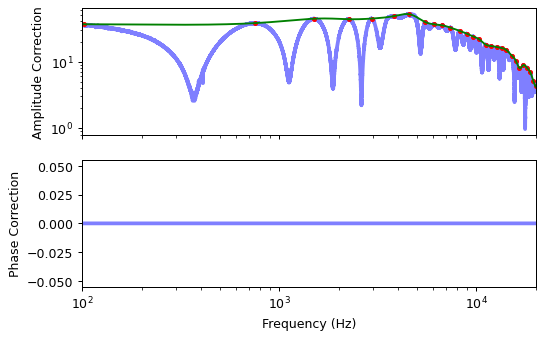

In [29]:
fig, axs = plt.subplots(2, 1, sharex=True, **figkwargs)
axs[0].loglog(f[0, 0], np.abs(amp_cal), 'b', alpha=0.5, lw=3)
axs[0].loglog(f[0, 0][amp_cal_max_inds], np.abs(amp_cal[amp_cal_max_inds]), 'r.')
axs[0].loglog(f[0, 0], amp_cal2, 'g')
axs[1].semilogx(f[0, 0], np.angle(amp_cal), 'b', alpha=0.5, lw=3)
# plt.ylim(1,500)
axs[0].set_ylabel("Amplitude Correction")
axs[1].set_ylabel("Phase Correction")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_xlim(100, 20000)
# plt.legend(range(12))

In [30]:
# Now, calibrate the amplitude using a VERY similar approach to older attempts, but using the B&K probe measured pressure
x_probe_offset = 0* units.mm

In [31]:
if False: # The old way of doing things
    mic_ref = channels[-1]
    trial = 0
    
    # NOTE :We can get more examples of amp_cal by using a different mic with the final mic (3 rounds in total)
    # TODO: USE ALL available MICs in the Calibration. 
    mic_p_correction = np.ones((len(channels)-1, p.shape[0], p.shape[-1]))
    for i, mic in enumerate(channels[:-1]): 
        p_probe_pred = cavern_model.p_measured(
            f[0, 0] * units.Hz,
            x_probe[0] + x_probe_offset,
            x_mic[mic], x_mic[mic_ref],
            p[:, trial, mic] * cal2[:, mic], p[:, trial, mic_ref] * cal2[:, mic_ref])
        # mic_p_correction[i] = np.abs(p_probe_pred)
        mic_p_correction[i] = np.abs(p_ref_on_f[:, trial] / p_probe_pred)
    
    # s_abs_amp = 0.5
    s_abs_amp = 2
    
    amp_cal = mic_p_correction.mean(axis=(0, 1))
    amp_cal = mic_p_correction[1:].mean(axis=(0, 1))
    amp_cal_b = 10**(np.log10(mic_p_correction).mean(axis=(0, 1)))
    amp_cal_orig = mic_p_correction.mean(axis=(0, 1))
    # TODO, make a better fit with ALL the data here, not just a mean of the data...
    # f_exp = f[:amp_cal.shape[1], trial][None].repeat(amp_cal.shape[0], axis=0) 
    f_exp = f[0,0] 
    # f_exp = f_exp + np.random.randn(*f_exp.shape)
    I = np.argsort(f_exp.ravel(order="F"))
    
    # Logarithm version
    amp_cal_spline = interpolate.splrep(
        np.log10(f_exp).ravel(order="F")[I],
        np.log10(np.abs(amp_cal)).ravel(order="F")[I], w=1 / (f_exp.ravel(order="F") / f.max())[I],
        s=s_abs_amp*f.shape[-1])
    amp_cal2 = 10**interpolate.splev(np.log10(f[0, 0]), amp_cal_spline)
    
    # Non-logarithm version
    # amp_cal_spline = interpolate.splrep(
    #     (f_exp).ravel(order="F")[I],
    #     np.log10(np.abs(amp_cal)).ravel(order="F")[I], w=1 / (f_exp.ravel(order="F") / f.max())[I],
    #     s=s_abs_amp*f.shape[-1])
    # amp_cal2 = 10**interpolate.splev((f[0, 0]), amp_cal_spline)

In [32]:
# plt.figure(**figkwargs)
# plt.loglog(f[0, 0], mic_p_correction[0].T, lw=0.1, alpha=1)
# plt.loglog(f[0, 0], mic_p_correction[1].T, lw=0.2, alpha=0.5)
# plt.loglog(f[0, 0], mic_p_correction[2].T, lw=0.3, alpha=0.25)
# # plt.loglog(f[0, 0], amp_cal_orig, 'k', alpha=0.5, lw=0.2)
# # plt.loglog(f[0, 0], amp_cal_b, 'r', alpha=0.75, lw=1)
# # plt.loglog(f[0, 0], amp_cal2, 'b', alpha=0.5, lw=3)
# plt.legend(range(8))

In [33]:
# # plt.plot(np.log10(f_exp).ravel(order="F"), np.log10(np.abs(amp_cal)).ravel(order="F"))
# plt.plot(np.log10(f_exp).ravel(order="F"), 1 / (f_exp.ravel(order="F") / f.max()))

In [34]:
if False: # The old way of doing things
    plt.figure(**figkwargs)
    plt.loglog(f[0, 0], mic_p_correction.reshape(np.prod(mic_p_correction.shape[:2]), -1).T, lw=0.1, alpha=0.5)
    plt.loglog(f[0, 0], amp_cal_orig, 'k', alpha=0.5, lw=1)
    # plt.loglog(f[0, 0], amp_cal_b, 'r', alpha=0.75, lw=1)
    plt.loglog(f[0, 0], amp_cal2, 'b', alpha=0.5, lw=3)
    plt.ylim(1,500)
    plt.ylabel("Amplitude Correction")
    plt.xlabel("Frequency (Hz)")
    plt.xlim(100, 20000)
    # plt.legend(range(12))

In [35]:
if False: # Old way of doing things
    plt.figure(**figkwargs)
    plt.semilogy(f[0, 0], mic_p_correction.reshape(np.prod(mic_p_correction.shape[:2]), -1).T, lw=0.1, alpha=0.5)
    plt.semilogy(f[0, 0], amp_cal, 'k', alpha=0.5, lw=1)
    # plt.semilogy(f[0, 0], amp_cal_b, 'r', alpha=0.75, lw=1)
    plt.semilogy(f[0, 0], amp_cal2, 'b', alpha=0.5, lw=3)

In [36]:
amp_cal = amp_cal2
# amp_cal = 10**np.log10(np.abs(amp_cal_orig)).mean(0)

In [37]:
# channel = 3
# mic1 = 1
# N = p_ref.shape[0]
# p_probe_pred2 = cavern_model.p_measured(
#     f[0, 0] * units.Hz,
#     x_probe[0] + x_probe_offset,
#     x_mic[mic1], x_mic[mic_ref],
#     p[:N, trial, mic1] * cal2[:, mic1] * amp_cal, p[:N, trial, mic_ref] * amp_cal)

# mic1 = 2
# p_probe_pred22 = cavern_model.p_measured(
#     f[0, 0] * units.Hz, 
#     x_probe[0] + x_probe_offset,
#     x_mic[mic1], x_mic[mic_ref],
#     p[:N, trial, mic1] * cal2[:, mic1] * amp_cal, p[:N, trial, mic_ref] * amp_cal)

# plt.figure(**figkwargs)
# plt.loglog(f_ref[0, 0], np.abs(p_probe_pred2[channel]).T, 'C0', alpha=0.9, label="Predicted", lw=0.2)
# plt.loglog(f_ref[0, 0], np.abs(p_probe_pred22[channel]).T, 'C1', alpha=0.5, label="Predicted", lw=0.2)
# plt.loglog(f_ref[0, 0], np.abs( p_ref[channel, trial]), 'k', alpha=0.5, label="Reference", lw=0.5)
# plt.legend()
# plt.figure(**figkwargs)
# plt.loglog(f_ref[0, 0], (np.abs( p[channel, trial, 1]) * cal2[:, 1]).T * amp_cal, 'C0', alpha=0.9, label="Predicted", lw=0.2)
# plt.loglog(f_ref[0, 0], (np.abs( p[channel, trial, 2]) * cal2[:, 2]).T * amp_cal, 'C1', alpha=0.5, label="Predicted", lw=0.2)
# # plt.loglog(f_ref[0, 0], (np.abs( p[channel, trial, 3]) * cal2[:, 3]).T, 'C2', alpha=0.5, label="Predicted", lw=0.2)
# plt.legend()

## Store the calibration data

In [38]:
calibration_data["cal"] = cal2 * amp_cal[:, None]

## Sanity Check

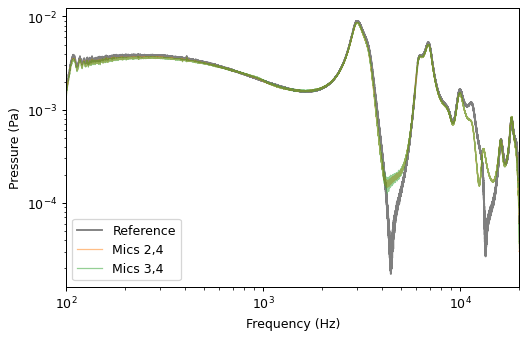

In [39]:
channel = 3
mic_ref = 3
mic1 = 0
N = p_ref.shape[0]
p_probe_pred2 = cavern_model.p_measured(
    f[0, 0] * units.Hz,
    x_probe[0] + x_probe_offset,
    x_mic[mic1], x_mic[mic_ref],
    p[:N, trial, mic1] * calibration_data["cal"][:, mic1], p[:N, trial, mic_ref] * calibration_data["cal"][:, mic_ref])

mic1 = 1
# mic2 = 2
p_probe_pred22 = cavern_model.p_measured(
    f[0, 0] * units.Hz, 
    x_probe[0] + x_probe_offset,
    x_mic[mic1], x_mic[mic_ref],
    p[:N, trial, mic1] * calibration_data["cal"][:, mic1], p[:N, trial, mic_ref] * calibration_data["cal"][:, mic_ref])
    # x_mic[mic1], x_mic[mic2],
    # p[:N, trial, mic1] * cal2[:, mic1] * amp_cal, p[:N, trial, mic2] * cal2[:, mic2] * amp_cal)

mic1 = 2
p_probe_pred23 = cavern_model.p_measured(
    f[0, 0] * units.Hz, 
    x_probe[0] + x_probe_offset,
    x_mic[mic1], x_mic[mic_ref],
    p[:N, trial, mic1] * calibration_data["cal"][:, mic1], p[:N, trial, mic_ref] * calibration_data["cal"][:, mic_ref])

plt.figure(**figkwargs)
plt.loglog(f_ref[0, 0], np.abs(p_ref[channel, trial]).T, 'k', alpha=0.5, label='Reference')
# plt.loglog(f[0, 0], np.abs(p_ref_on_f[channel, trial]).T, 'r-', alpha=1, lw=0.2, label='Reference')
# plt.loglog(f_ref[0, 0], np.abs(p_probe_pred2[channel]).T, 'C0', alpha=0.5, label="Predicted", lw=1)
plt.loglog(f_ref[0, 0], np.abs(p_probe_pred22[channel]).T, 'C1', alpha=0.5, label="Mics 2,4", lw=1)
plt.loglog(f_ref[0, 0], np.abs(p_probe_pred23[channel]).T, 'C2', alpha=0.5, label="Mics 3,4", lw=1)
plt.xlim(100, 20000)
plt.ylabel("Pressure (Pa)")
plt.xlabel("Frequency (Hz)")
plt.legend()

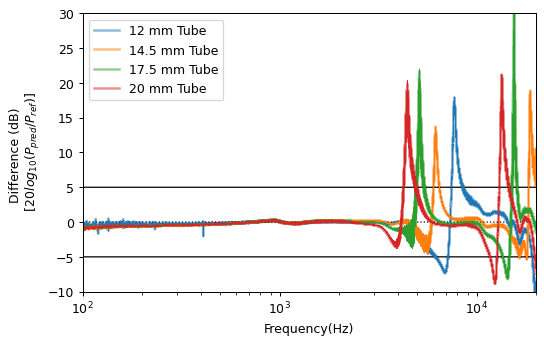

In [40]:
plt.figure(**figkwargs)
plt.semilogx(f_ref[0, 0], todB(p_probe_pred22).T - todB(p_ref[:, 0].T), '-', alpha=0.5, lw=2)
plt.semilogx(f[0, 0], f[0, 0]*0 + 5, 'k', lw=1, alpha=1)
plt.semilogx(f[0, 0], f[0, 0]*0 - 5, 'k', lw=1, alpha=1)
plt.semilogx(f[0, 0], f[0, 0]*0  , 'k:', lw=1, alpha=1)
# plt.semilogx(f_ref[0, 0], todB(p_probe_pred2).T - todB(p_ref[:, 0].T), 'C0', alpha=0.25, lw=0.2)
plt.gca().set_prop_cycle(None)
plt.semilogx(f_ref[0, 0], todB(p_probe_pred23).T - todB(p_ref[:, 0].T), '-', alpha=1, lw=0.5)

# Linear x-scale version
# plt.plot(f[0, 0], f[0, 0]*0 + 5, 'k', lw=1, alpha=1)
# plt.plot(f[0, 0], f[0, 0]*0 - 5, 'k', lw=1, alpha=1)
# plt.plot(f[0, 0], f[0, 0]*0  , 'k:', lw=1, alpha=1)
# plt.plot(f_ref[0, 0], todB(p_probe_pred2).T - todB(p_ref[:, 0].T), 'C0', alpha=0.25, lw=0.2)
# plt.plot(f_ref[0, 0], todB(p_probe_pred22).T - todB(p_ref[:, 0].T), 'C1', alpha=0.25, lw=0.2)
# plt.plot(f_ref[0, 0], todB(p_probe_pred23).T - todB(p_ref[:, 0].T), 'C2', alpha=0.25, lw=0.2)

# This is the same thing
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred2) / p_ref[:, 0]).T, 'C0', alpha=0.25, lw=0.2)
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred22) / p_ref[:, 0]).T, 'C1', alpha=0.25, lw=0.2)
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred23) / p_ref[:, 0]).T, 'C2', alpha=0.25, lw=0.2)
plt.ylabel('Difference (dB) \n [$20log_{10}(P_{pred} / P_{ref})$]')
plt.xlabel('Frequency(Hz)')
plt.ylim([-10, 30])
plt.xlim([100, 20000])
plt.legend(["12 mm Tube", "14.5 mm Tube", "17.5 mm Tube", "20 mm Tube"])

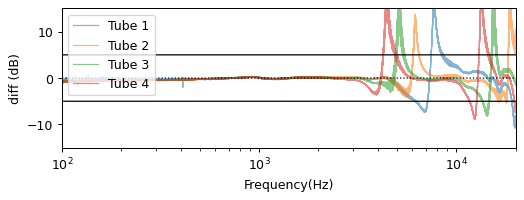

In [41]:
myfigkwars = figkwargs.copy()
myfigkwars['figsize'] = (6.5, 6.5/1.618034 / 2)
plt.figure(**myfigkwars)
plt.semilogx(f_ref[0, 0], todB(p_probe_pred22).T - todB(p_ref[:, 0].T), alpha=0.55, lw=1)
plt.semilogx(f[0, 0], f[0, 0]*0 + 5, 'k', lw=1, alpha=1)
plt.semilogx(f[0, 0], f[0, 0]*0 - 5, 'k', lw=1, alpha=1)
plt.semilogx(f[0, 0], f[0, 0]*0  , 'k:', lw=1, alpha=1)
# plt.semilogx(f_ref[0, 0], todB(p_probe_pred2).T - todB(p_ref[:, 0].T), 'C0', alpha=0.25, lw=0.2)
# plt.semilogx(f_ref[0, 0], todB(p[:N, trial, 1] * cal2[:, 1] * amp_cal).T - todB(p_ref[:, 0].T), 'C2', alpha=0.25, lw=0.2)
# plt.semilogx(f_ref[0, 0], todB(p_probe_pred23).T - todB(p_ref[:, 0].T), 'C2', alpha=0.25, lw=0.2)

# Linear x-scale version
# plt.plot(f[0, 0], f[0, 0]*0 + 5, 'k', lw=1, alpha=1)
# plt.plot(f[0, 0], f[0, 0]*0 - 5, 'k', lw=1, alpha=1)
# plt.plot(f[0, 0], f[0, 0]*0  , 'k:', lw=1, alpha=1)
# plt.plot(f_ref[0, 0], todB(p_probe_pred2).T - todB(p_ref[:, 0].T), 'C0', alpha=0.25, lw=0.2)
# plt.plot(f_ref[0, 0], todB(p_probe_pred22).T - todB(p_ref[:, 0].T), 'C1', alpha=0.25, lw=0.2)
# plt.plot(f_ref[0, 0], todB(p_probe_pred23).T - todB(p_ref[:, 0].T), 'C2', alpha=0.25, lw=0.2)

# This is the same thing
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred2) / p_ref[:, 0]).T, 'C0', alpha=0.25, lw=0.2)
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred22) / p_ref[:, 0]).T, 'C1', alpha=0.25, lw=0.2)
# plt.semilogx(f_ref[0, 0], 20*np.log10(np.abs(p_probe_pred23) / p_ref[:, 0]).T, 'C2', alpha=0.25, lw=0.2)
plt.ylabel('diff (dB)')
plt.xlabel('Frequency(Hz)')
plt.ylim([-15, 15])
plt.xlim([100, 20000])
plt.legend(["Tube 1", "Tube 2", "Tube 3", "Tube 4"])

# 1.b Speaker Calibration

In [42]:
# Get the coefficients of the forward and reverse waves for all 4 tubes
mic1 = 1
mic2 = 3
trial = 0
k = cavern_model.k(f[0, 0] * units.Hz)
A0 = cavern_model.A_measured(k, x=None,
                             x0=x_mic[mic1], x1=x_mic[mic2], 
                             p0=p[:, trial, mic1] * calibration_data["cal"][:, mic1],
                             p1=p[:, trial, mic2] * calibration_data["cal"][:, mic2]).magnitude
B0 = cavern_model.B_measured(k, x=None,
                             x0=x_mic[mic1], x1=x_mic[mic2], 
                             p0=p[:, trial, mic1] * calibration_data["cal"][:, mic1],
                             p1=p[:, trial, mic2] * calibration_data["cal"][:, mic2]).magnitude
p0 = cavern_model.p_measured(f[0, 0] * units.Hz, x=x_probe[0],
                             x0=x_mic[mic1], x1=x_mic[mic2], 
                             p0=p[:, trial, mic1] * calibration_data["cal"][:, mic1],
                             p1=p[:, trial, mic2] * calibration_data["cal"][:, mic2]).magnitude
p_probe_pred22 = cavern_model.p_measured(
    f[0, 0] * units.Hz, 
    x_probe[0] + x_probe_offset,
    x_mic[mic1], x_mic[mic_ref],
    p[:N, trial, mic1] * calibration_data["cal"][:, mic1], p[:N, trial, mic_ref] * calibration_data["cal"][:, mic_ref])

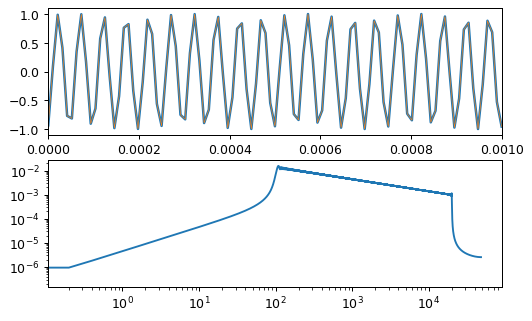

In [43]:
# Let's make a reference chirp -- so the expected A0
duration = test_meta['chirp_parameters']['end_time']['value'] - test_meta['chirp_parameters']['start_time']['value']
f0 = test_meta['chirp_parameters']['start_freq']['value']
f1 = test_meta['chirp_parameters']['end_freq']['value']
chirp_times = np.linspace(0, duration, int(samplerate * duration))
chirp = signal.chirp(chirp_times, f0, chirp_times[-1], f1, 'logarithmic')
chirp_f, chirp_p = spu.to_fourier(chirp, samplerate)
chirp_keep_inds = (chirp_f >= 100) & (chirp_f < 20000)

# test 
chirp2 = spu.from_fourier(chirp_p)
fig, axs = plt.subplots(2, 1, **figkwargs)
axs[0].plot(chirp_times, chirp, lw=2)
axs[0].plot(chirp_times, chirp2, lw=0.5)
axs[0].set_xlim(4.999, 5)
axs[1].loglog(chirp_f, np.abs(chirp_p))

(-180.0, 180.0)

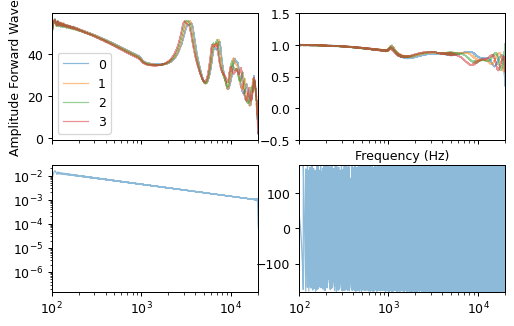

In [44]:
R = (B0 / A0)
fig, axs = plt.subplots(2, 2, sharex=True, **figkwargs)
axs[0, 0].semilogx(f[0, 0], todB(np.abs(A0)).T, alpha=0.5, lw=1)
# axs[0, 0].semilogx(f_ref[0,0], todB(p_ref[0, 0]).T, lw=0.5)
# axs[0, 0].semilogx(f_ref[0, 0], todB(p0).T, 'm', lw=0.5)
# axs[0, 0].semilogx(f[0, 0], todB(p_probe_pred22[0]).T, 'g', lw=0.5)
# axs[1, 0].semilogx(f[0, 0], np.rad2deg(np.angle(A0)).T, alpha=0.5, lw=1)
axs[0, 0].legend(range(A0.shape[0]))
axs[1, 0].loglog(chirp_f, np.abs(chirp_p), alpha=0.5, lw=1)
axs[0, 1].semilogx(f[0, 0], np.abs(R).T, alpha=0.5, lw=1)
# axs[1, 1].semilogx(f[0, 0], np.rad2deg(np.angle(R)).T, alpha=0.5, lw=1)
axs[1, 1].semilogx(chirp_f, np.rad2deg(np.angle(chirp_p)).T, alpha=0.5, lw=1)
# axs[1, 1].semilogx(f[0, 0], np.rad2deg(np.angle(A0 / chirp_p)).T, alpha=0.5, lw=1)
# plt.ylim(1,500)
axs[0, 0].set_ylabel("Amplitude Forward Wave")
axs[0, 1].set_xlabel("Frequency (Hz)")
axs[0, 0].set_xlim(100, 20000)
# axs[0, 0].set_ylim(20, 40)
axs[0, 1].set_ylim(-0.5, 1.5)
axs[1, 1].set_ylim(-180, 180)
# axs[1, 0].set_ylim(-180, 180)
# plt.legend(range(p.shape[0]))

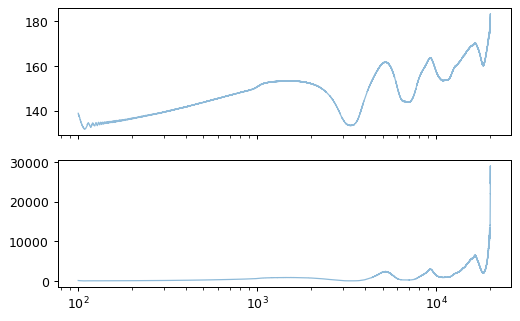

In [45]:
# We want A to be flat, so find multiplier for speaker so that A is flat:
# A*(f) = 1 = A * C_speaker ==> C_speaker = 1/A
speaker_cal = 1 / 10**(np.log10(np.abs(A0)).mean(axis=0))
fig, axs = plt.subplots(2, 1, sharex=True, **figkwargs)

# axs[0].plot(f[0, 0], todB(A0).mean(0).T, alpha=0.5, lw=1)
axs[0].semilogx(f[0, 0], todB(speaker_cal).T, alpha=0.5, lw=1)
axs[1].plot(f[0, 0], (speaker_cal).T, alpha=0.5, lw=1)

0.9561106827520752


(-0.25, 5.25)

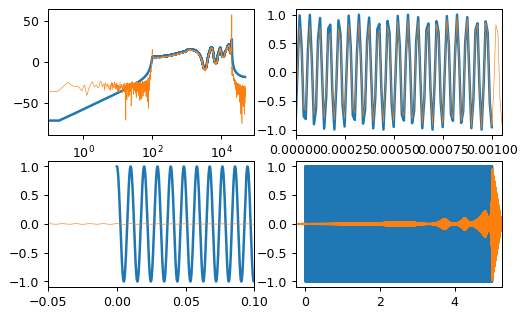

In [46]:
# From test_meta, the level set at the Tympan was -24dB -- so -24dB translated to actual DB as follows
speaker_cal_fraction = speaker_cal / np.max(speaker_cal)
speaker_I = np.argwhere(speaker_cal_fraction == 1)[0, 0]
dB_conversion = todB(A0[:, speaker_I]).mean(0) + 24

chirp_cal_p = np.zeros_like(chirp_p)
# chirp_cal_p = chirp_p.copy()
# chirp_cal_p[chirp_keep_inds] = chirp_p[chirp_keep_inds] * np.interp(chirp_f[chirp_keep_inds], f[0, 0], speaker_cal_fraction)
chirp_cal_p = chirp_p * np.interp(chirp_f, f[0, 0], speaker_cal_fraction)
chirp_cal = spu.from_fourier(chirp_cal_p)


# def pad_chirp(times, signal, f0, f1, pad_time, phi=0):
#     dt = times[1] - times[0]
#     n = int(pad_time // dt)
#     pad_time = n * dt
#     pad_times = np.linspace(0, pad_time, n)
#     new_times = np.concatenate([pad_times - pad_time - dt, times, pad_times + times.max() + dt])
#     a0 = signal[0] / np.cos(2 * np.pi * f0 * times[0] + phi) * pad_times / pad_times.max()
#     a1 = signal[-1] / np.cos(2 * np.pi * f0 * times[-1] + phi) * pad_times[::-1] / pad_times.max()
#     new_signal = np.concatenate([
#         np.cos(2 * np.pi * f0 * new_times[:n] + phi) * a0,
#         signal,
#         np.cos(2 * np.pi * f1 * new_times[-n:] + phi) * a1
#     ])
#     return new_times, new_signal

# def make_chirp(times, f0, f1, amplitude_func=None, phi=0, pad_time=0):
#     if amplitude_func is None: 
#         amplitude_func = lambda f: 1
#     t1 = times.max()
#     # See https://en.wikipedia.org/wiki/Chirp#Exponential
#     freq = f0 * (pow(f1 / f0, (times / t1)))
#     beta = t1 / np.log(f1 / f0)
#     phase = 2 * np.pi * beta * (freq - f0)  # -f0 is a phase shift because scipy uses cos and wikipedia uses sin
#     signal = amplitude_func(freq) * np.cos(phase + phi)
#     return signal

amplitude = lambda freq: np.interp(freq, f[0, 0], speaker_cal_fraction)
chirp_cal = spu.make_chirp(chirp_times, f0, f1, amplitude)
# chirp_cal = spu.make_chirp(chirp_times, f0, f1)
chirp2_times = chirp_times
chirp2_times, chirp_cal = spu.pad_chirp(chirp_times, chirp_cal, f0, f1, 0.25)

print(chirp_cal.max())

chirp_f2, chirp_p2 = spu.to_fourier(chirp_cal, samplerate)

fig, axs = plt.subplots(2,2, **figkwargs)
# axs[0, 0].semilogx(chirp_f, todB(chirp_p))# * speaker_cal_fraction)
axs[0, 0].semilogx(chirp_f, todB(chirp_cal_p), lw=2)# * speaker_cal_fraction)
axs[0, 0].semilogx(chirp_f2, todB(chirp_p2), lw=0.5)
# axs[0, 0].semilogx(chirp_f2[chirp_keep_inds], todB(chirp_p2[chirp_keep_inds]))
# axs[0, 0].semilogx(chirp_f[chirp_keep_inds], todB(chirp_p[chirp_keep_inds]) * speaker_cal_fraction)
# axs[0, 0].set_xlim(100, 300)
axs[1, 0].plot(chirp_times, chirp, lw=2)
axs[1, 0].plot(chirp2_times, chirp_cal, lw=0.5)
axs[1, 0].set_xlim(-0.05, 0.1)
# axs[1, 0].set_xlim(1.0367-0.01, 1.0367+0.01)
# axs[1, 0].set_ylim(-0.1, 0.1)
axs[0, 1].plot(chirp_times, chirp, lw=2)
axs[0, 1].plot(chirp2_times, chirp_cal, lw=0.5)
axs[0, 1].set_xlim(4.999, 5.00005)
axs[1, 1].plot(chirp_times, chirp)
axs[1, 1].plot(chirp2_times, chirp_cal)
axs[1, 1].set_xlim(-0.25, 5.25)

In [47]:
# save the calibration data for the speaker
calibration_data['speaker'] = {
    'dB_FS_to_SPL': dB_conversion,
    "notes": "If specifying -X dB on the tympan, the actual SPL dB is -X + dB_conversion",
    "frequency": f[0, 0],
    "fraction_cal": speaker_cal_fraction,
    "cal": speaker_cal
}

## 1.C Save calibration to disk

In [48]:
# cal_final_filename = 'test.yaml'
cal_final_filename = io.save_calibration_data(path, calibration_data)
io.write_wav(cal_final_filename.replace('.yaml', 'i16.wav'), chirp_cal[:, None].repeat(2, axis=1), samplerate, np.int16)
# io.write_wave(cal_final_filename.replace('.yaml', 'spi16.wav'), chirp[:, None].repeat(2, axis=1), samplerate, np.int16)
# sig3 = spu.from_fourier(p[0, 0, 3])
# sig3 = sig3 / np.max(np.abs(sig3))
# io.write_wave(cal_final_filename.replace('.yaml', 'p16.wav'), sig3[:, None].repeat(2, axis=1), samplerate, np.int16)

# 2. Validation

## Load the SImulator data

In [49]:
test_keys = [
    'Simulator_A_B&K_in_closer_probe_port_further_sealed',
    'Simulator_A_B&K_in_further_probe_port_closer_sealed',
    'Simulator_B_B&K_in_closer_probe_port_further_sealed',
    'Simulator_B_B&K_in_further_probe_port_closer_sealed',
]

# make sure all the data has the same shape
fn = os.path.join(path, test_meta["test_metadata"][test_keys[0]]["files"][0][0])
_, _, samplerate = io.load_wav(fn)
duration = test_meta["chirp_parameters"]["end_time"]["value"] - test_meta["chirp_parameters"]["start_time"]["value"]
data_slice = slice(
    int(test_meta["chirp_parameters"]["start_time"]["value"] * samplerate),
    int(test_meta["chirp_parameters"]["end_time"]["value"] * samplerate), None)

times = {}
data = {}
times_ref = {}
data_ref = {}
for i, test_key in enumerate(test_keys):
    cavern_times = []
    cavern_data = []
    cavern_times_ref = []
    cavern_data_ref = []
    for j, tests in enumerate(test_meta["test_metadata"][test_key]["files"]):
        fn = os.path.join(path, tests[0])
        t, d, samplerate = io.load_wav(fn, )
        cavern_times.append(t[data_slice])
        cavern_data.append(d[data_slice].T)
        if len(tests) == 1:
            continue
        fn = os.path.join(path, tests[1])
        t, d, samplerate_bk = io.load_wav(fn)
        slc = spu.trim_signal_sharp_jump(d, samplerate_bk, duration=5, kernel_size=65, end=True, return_index=True)
        cavern_times_ref.append(t[slc])
        cavern_data_ref.append(d[slc].T)
    times[test_key] = cavern_times
    data[test_key] = cavern_data
    times_ref[test_key] = cavern_times_ref
    data_ref[test_key] = cavern_data_ref
# Done reading all the data

Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Using scaling data from  /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-07-01_AurenV1_calibration-data-collection/BKProbe_012.dat
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Using scaling data from  /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-07-01

## Fourier Transforms and Data Wrangling

In [50]:
# Use last two tests
f_ref = []
p_ref = []
p = []
f = []
for key in test_keys:
    this_p_ref = []
    this_f_ref = []
    this_p = []
    this_f = []
    for test in [-2, -1]:
        my_f, my_p = spu.to_fourier(data[key][test], samplerate)
        keep_inds = (my_f >= 100) & (my_f < 20000)
        my_f = my_f[keep_inds]
        my_p = my_p[:, keep_inds]
        this_p.append(my_p)
        this_f.append(my_f)
        if not data_ref[key]:
            continue
        my_f_ref, my_p_ref = spu.to_fourier(data_ref[key][test], samplerate_bk)
        keep_inds = (my_f_ref >= 100) & (my_f_ref < 20000)
        my_f_ref = my_f_ref[keep_inds]
        my_p_ref = my_p_ref[keep_inds]
        this_p_ref.append(my_p_ref)
        this_f_ref.append(my_f_ref)

    this_p = np.stack(this_p, axis=0)
    this_f = np.stack(this_f, axis=0)
    p.append(this_p)
    f.append(this_f)
    if not this_p_ref:
        continue
    this_p_ref = np.stack(this_p_ref, axis=0)
    this_f_ref = np.stack(this_f_ref, axis=0)
    p_ref.append(this_p_ref)
    f_ref.append(this_f_ref)
p = np.stack(p, axis=0)
f = np.stack(f, axis=0)
p_ref = np.stack(p_ref, axis=0)
f_ref = np.stack(f_ref, axis=0)
axis_order = ['test_geometry', 'test_iteration', "channel", 'data']

In [51]:
p_cal = p * calibration_data["cal"].T

## Check loaded data looks reasonable... Plot

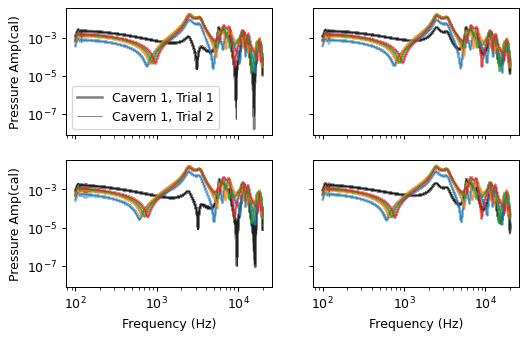

In [52]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)
ref_channel = 3
lines = ['-', '--']
for i in range(4):
    ii = i // 2
    jj = i % 2
    for j in range(2):
        axs[ii,jj].loglog(f_ref[i, j], np.abs(p_ref[i, j, :]), 'k', label="Cavern {}, Trial {}".format(i+1,j+1), lw=2-j*1.5, alpha=0.5 + 0.25 * j)
        if i == 0: axs[ii,jj].legend()
    for j in range(2):
        axs[ii,jj].set_prop_cycle(None)
        axs[ii,jj].loglog(f[i, j], np.abs(p_cal[i, j, :, :]).T, label="Trial {}".format(j + 1), lw=2-j*1.5, alpha=0.5 + 0.25 * j)
axs[-1, 0].set_xlabel('Frequency (Hz)')
axs[-1, 1].set_xlabel('Frequency (Hz)')
axs[0, 0].set_ylabel('Pressure Amp(cal)')
axs[-1, 0].set_ylabel('Pressure Amp(cal)')
plt.show()

## Predict B&K Pressure

In [53]:
length_probe = get_meta_value_units("probe_geometry", "length")
x_mic = get_meta_value_units('probe_geometry', 'mic_positions')
diameter_probe = get_meta_value_units('probe_geometry', 'interior_diameter')
diameter_simulator = [get_meta_value_units("test_geometry", "simulator_" + ["A", "B"][i], "interior_diameter") for i in range(2)]
x_probe_simulators = [
    length_probe + get_meta_value_units("test_geometry", "simulator_" + ["A", "B"][i], "x_of_probe")
    for i in range(2)
    ]

In [54]:
f.shape, p_cal.shape

((4, 2, 99500), (4, 2, 4, 99500))

In [55]:
simA = 0
simB = 1
trial = 0
simAmic13 = TwoDiameterTube(x_mic[1], x_mic[3], length_probe, diameter_probe, diameter_simulator[simA])
pA13_pred_closer  = simAmic13.p_measured(f[simA, trial] * units.Hz, x_probe_simulators[simA][0], p_cal[simA, trial, 1], p_cal[simA, trial, 3])
pA13_pred_further = simAmic13.p_measured(f[simA + 1, trial] * units.Hz, x_probe_simulators[simA][1], p_cal[simA + 1, trial, 1], p_cal[simA + 1, trial, 3])

simBmic13 = TwoDiameterTube(x_mic[1], x_mic[3], length_probe, diameter_probe, diameter_simulator[simB])
pB13_pred_closer  = simBmic13.p_measured(f[2 * simB, trial] * units.Hz, x_probe_simulators[simB][0], p_cal[2 * simB, trial, 1], p_cal[2 * simB, trial, 3])
pB13_pred_further = simBmic13.p_measured(f[2 * simB + 1, trial] * units.Hz, x_probe_simulators[simB][1], p_cal[2 * simB + 1, trial, 1], p_cal[2 * simB + 1, trial, 3])

In [56]:
f_ref.shape, p_ref.shape

((4, 2, 99500), (4, 2, 99500))

Text(0, 0.5, 'Sim. B Pressure (Pa)')

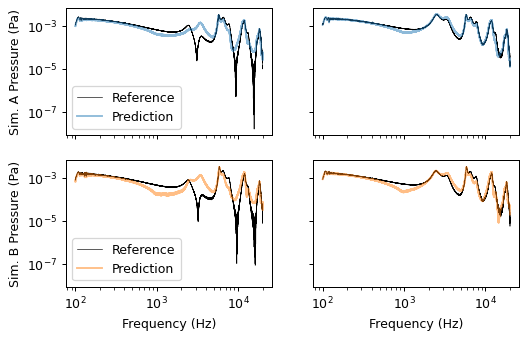

In [57]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)
axs[0, 0].loglog(f_ref[0, trial], np.abs(p_ref[simA, trial]), 'k', label="Reference", lw=0.5)
axs[0, 0].loglog(f[0, trial], np.abs(pA13_pred_closer), 'C0', label="Prediction", alpha=0.5)
axs[0, 0].legend()
axs[0, 1].loglog(f_ref[1, trial], np.abs(p_ref[simA + 1, trial]), 'k', label="Reference", lw=0.5)
axs[0, 1].loglog(f[1, trial], np.abs(pA13_pred_further), 'C0', label="Prediction", alpha=0.5)

axs[1, 0].loglog(f_ref[0, trial], np.abs(p_ref[simB * 2, trial]), 'k', label="Reference", lw=0.5)
axs[1, 0].loglog(f[0, trial], np.abs(pB13_pred_closer), 'C1', label="Prediction", alpha=0.5)
axs[1, 1].loglog(f_ref[1, trial], np.abs(p_ref[simB * 2 + 1, trial]), 'k', label="Reference", lw=0.5)
axs[1, 1].loglog(f[1, trial], np.abs(pB13_pred_further), 'C1', label="Prediction", alpha=0.5)
# axs[1, 1].loglog(f_ref[1, trial], np.abs(p_ref[simA + 1, trial]), 'k', label="ReferenceA", lw=0.3, alpha=0.5)
# axs[1, 1].loglog(f[1, trial], np.abs(pA_pred_further), 'C0', label="PredictionA", lw=0.3, alpha=0.5)

axs[1, 0].legend()
axs[1, 0].set_xlabel("Frequency (Hz)")
axs[1, 1].set_xlabel("Frequency (Hz)")
axs[0, 0].set_ylabel("Sim. A Pressure (Pa)")
axs[1, 0].set_ylabel("Sim. B Pressure (Pa)")

/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/pint/facets/plain/quantity.py:587: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._convert_magnitude_not_inplace(UnitsContainer()))
/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Sim. B Difference (dB) \n [$20log_{10}(P_{pred} / P_{ref})$]')

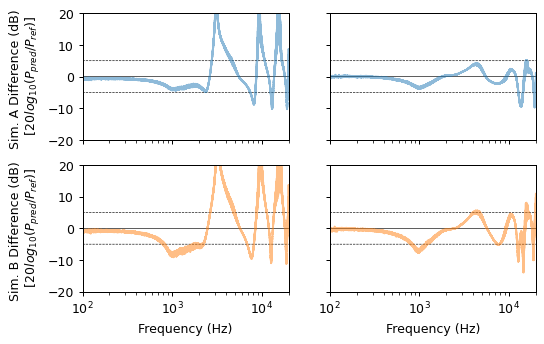

In [58]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)

axs[0, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], 20 * np.log10(pA13_pred_closer / p_ref[simA, trial]), 'C0', alpha=0.5)

axs[0, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], 20 * np.log10(pA13_pred_further / p_ref[simA + 1, trial]), 'C0', alpha=0.5)

axs[1, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], 20 * np.log10(pB13_pred_closer / p_ref[simB * 2, trial]), 'C1', alpha=0.5)

axs[1, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], 20 * np.log10(pB13_pred_further / p_ref[simB * 2 + 1, trial]), 'C1', alpha=0.5)

axs[0, 0].set_ylim(-20, 20)
axs[0, 0].set_xlim(100, 20000)
axs[1, 0].set_xlabel("Frequency (Hz)")
axs[1, 1].set_xlabel("Frequency (Hz)")
axs[0, 0].set_ylabel('Sim. A Difference (dB) \n [$20log_{10}(P_{pred} / P_{ref})$]')
axs[1, 0].set_ylabel('Sim. B Difference (dB) \n [$20log_{10}(P_{pred} / P_{ref})$]')

### Weigthed pressure prediction

In [59]:
# Let's see if we can do better with a weighted difference between the mics combinations
simA = 0
simB = 1
trial = 0
simAmic12 = TwoDiameterTube(x_mic[1], x_mic[2], length_probe, diameter_probe, diameter_simulator[simA])
pA12_pred_closer  = simAmic13.p_measured(f[simA, trial] * units.Hz, x_probe_simulators[simA][0], p_cal[simA, trial, 1], p_cal[simA, trial, 2])
pA12_pred_further = simAmic13.p_measured(f[simA + 1, trial] * units.Hz, x_probe_simulators[simA][1], p_cal[simA + 1, trial, 1], p_cal[simA + 1, trial, 2])
simAmic23 = TwoDiameterTube(x_mic[2], x_mic[3], length_probe, diameter_probe, diameter_simulator[simA])
pA23_pred_closer  = simAmic13.p_measured(f[simA, trial] * units.Hz, x_probe_simulators[simA][0], p_cal[simA, trial, 2], p_cal[simA, trial, 3])
pA23_pred_further = simAmic13.p_measured(f[simA + 1, trial] * units.Hz, x_probe_simulators[simA][1], p_cal[simA + 1, trial, 2], p_cal[simA + 1, trial, 3])

simBmic12 = TwoDiameterTube(x_mic[1], x_mic[2], length_probe, diameter_probe, diameter_simulator[simB])
pB12_pred_closer  = simBmic13.p_measured(f[2 * simB, trial] * units.Hz, x_probe_simulators[simB][0], p_cal[2 * simB, trial, 1], p_cal[2 * simB, trial, 2])
pB12_pred_further = simBmic13.p_measured(f[2 * simB + 1, trial] * units.Hz, x_probe_simulators[simB][1], p_cal[2 * simB + 1, trial, 1], p_cal[2 * simB + 1, trial, 2])
simBmic23 = TwoDiameterTube(x_mic[2], x_mic[3], length_probe, diameter_probe, diameter_simulator[simB])
pB23_pred_closer  = simBmic13.p_measured(f[2 * simB, trial] * units.Hz, x_probe_simulators[simB][0], p_cal[2 * simB, trial, 2], p_cal[2 * simB, trial, 3])
pB23_pred_further = simBmic13.p_measured(f[2 * simB + 1, trial] * units.Hz, x_probe_simulators[simB][1], p_cal[2 * simB + 1, trial, 2], p_cal[2 * simB + 1, trial, 3])

In [60]:
# We've got all the signals, let's get all the weights
def get_weights(p, ind0, ind1):
    return np.minimum(np.abs(p[ind0]), np.abs(p[ind1]))
weights_A12_closer = get_weights(p_cal[simA, trial], 1, 2)
weights_A13_closer = get_weights(p_cal[simA, trial], 1, 3)
weights_A23_closer = get_weights(p_cal[simA, trial], 2, 3)
weigthsA_closer_sum = weights_A12_closer + weights_A13_closer +weights_A23_closer
pA_pred_closer_weighted = (weights_A12_closer * pA12_pred_closer + weights_A13_closer * pA13_pred_closer + weights_A23_closer * pA23_pred_closer) / weigthsA_closer_sum

weights_A12_further = get_weights(p_cal[simA + 1, trial], 1, 2)
weights_A13_further = get_weights(p_cal[simA + 1, trial], 1, 3)
weights_A23_further = get_weights(p_cal[simA + 1, trial], 2, 3)
weigthsB_further_sum = weights_A12_further + weights_A13_further + weights_A23_further
pA_pred_further_weighted = (weights_A12_further * pA12_pred_further + weights_A13_further * pA13_pred_further + weights_A23_further * pA23_pred_further) / weigthsB_further_sum

weights_B12_closer = get_weights(p_cal[simB * 2, trial], 1, 2)
weights_B13_closer = get_weights(p_cal[simB * 2, trial], 1, 3)
weights_B23_closer = get_weights(p_cal[simB * 2, trial], 2, 3)
weigthsB_closer_sum = weights_B12_closer + weights_B13_closer +weights_B23_closer
pB_pred_closer_weighted = (weights_B12_closer * pB12_pred_closer + weights_B13_closer * pB13_pred_closer + weights_B23_closer * pB23_pred_closer) / weigthsB_closer_sum

weights_B12_further = get_weights(p_cal[simB * 2 + 1, trial], 1, 2)
weights_B13_further = get_weights(p_cal[simB * 2 + 1, trial], 1, 3)
weights_B23_further = get_weights(p_cal[simB * 2 + 1, trial], 2, 3)
weigthsB_further_sum = weights_B12_further + weights_B13_further + weights_B23_further
pB_pred_further_weighted = (weights_B12_further * pB12_pred_further + weights_B13_further * pB13_pred_further + weights_B23_further * pB23_pred_further) / weigthsB_further_sum


Text(0, 0.5, 'Sim. B Difference (dB) \n [$20log_{10}(P_{pred} / P_{ref})$]')

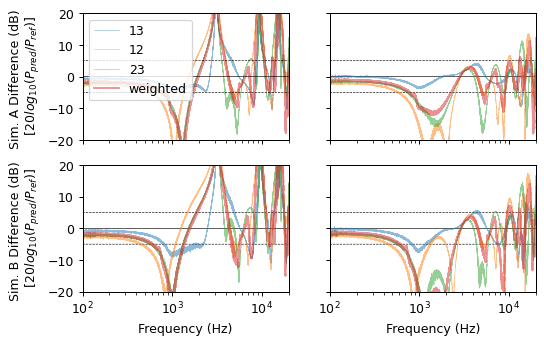

In [61]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)

axs[0, 0].semilogx(f_ref[0, trial], 20 * np.log10(pA13_pred_closer / p_ref[simA, trial]), 'C0', alpha=0.5, lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], 20 * np.log10(pA12_pred_closer / p_ref[simA, trial]), 'C1', alpha=0.5, lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], 20 * np.log10(pA23_pred_closer / p_ref[simA, trial]), 'C2', alpha=0.5, lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], 20 * np.log10(pA_pred_closer_weighted / p_ref[simA, trial]), 'C3', alpha=0.5)
axs[0, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)

axs[0, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], 20 * np.log10(pA13_pred_further / p_ref[simA + 1, trial]), 'C0', alpha=0.5, lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], 20 * np.log10(pA12_pred_further / p_ref[simA + 1, trial]), 'C1', alpha=0.5, lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], 20 * np.log10(pA23_pred_further / p_ref[simA + 1, trial]), 'C2', alpha=0.5, lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], 20 * np.log10(pA_pred_further_weighted / p_ref[simA + 1, trial]), 'C3', alpha=0.5)

axs[1, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], 20 * np.log10(pB13_pred_closer / p_ref[simB * 2, trial]), 'C0', alpha=0.5, lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], 20 * np.log10(pB12_pred_closer / p_ref[simB * 2, trial]), 'C1', alpha=0.5, lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], 20 * np.log10(pB23_pred_closer / p_ref[simB * 2, trial]), 'C2', alpha=0.5, lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], 20 * np.log10(pB_pred_closer_weighted / p_ref[simB * 2, trial]), 'C3', alpha=0.5)

axs[1, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], 20 * np.log10(pB13_pred_further / p_ref[simB * 2 + 1, trial]), 'C0', alpha=0.5, lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], 20 * np.log10(pB12_pred_further / p_ref[simB * 2 + 1, trial]), 'C1', alpha=0.5, lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], 20 * np.log10(pB23_pred_further / p_ref[simB * 2 + 1, trial]), 'C2', alpha=0.5, lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], 20 * np.log10(pB_pred_further_weighted / p_ref[simB * 2 + 1, trial]), 'C3', alpha=0.5)

axs[0, 0].legend(["13", "12", "23", "weighted"])
axs[0, 0].set_ylim(-20, 20)
axs[0, 0].set_xlim(100, 20000)
axs[1, 0].set_xlabel("Frequency (Hz)")
axs[1, 1].set_xlabel("Frequency (Hz)")
axs[0, 0].set_ylabel('Sim. A Difference (dB) \n [$20log_{10}(P_{pred} / P_{ref})$]')
axs[1, 0].set_ylabel('Sim. B Difference (dB) \n [$20log_{10}(P_{pred} / P_{ref})$]')

### Weighted but only the amplitude

In [62]:
# We've got all the signals, let's get all the weights
def get_weights(p, ind0, ind1):
    return np.minimum(np.abs(p[ind0]), np.abs(p[ind1]))
weights_A12_closer = get_weights(p_cal[simA, trial], 1, 2)
weights_A13_closer = get_weights(p_cal[simA, trial], 1, 3)
weights_A23_closer = get_weights(p_cal[simA, trial], 2, 3)
weigthsA_closer_sum = weights_A12_closer + weights_A13_closer +weights_A23_closer
pA_pred_closer_weighted = (weights_A12_closer * np.abs(pA12_pred_closer) + weights_A13_closer * np.abs(pA13_pred_closer) + weights_A23_closer * np.abs(pA23_pred_closer)) / weigthsA_closer_sum

weights_A12_further = get_weights(p_cal[simA + 1, trial], 1, 2)
weights_A13_further = get_weights(p_cal[simA + 1, trial], 1, 3)
weights_A23_further = get_weights(p_cal[simA + 1, trial], 2, 3)
weigthsB_further_sum = weights_A12_further + weights_A13_further + weights_A23_further
pA_pred_further_weighted = (weights_A12_further * np.abs(pA12_pred_further) + weights_A13_further * np.abs(pA13_pred_further) + weights_A23_further * np.abs(pA23_pred_further)) / weigthsB_further_sum

weights_B12_closer = get_weights(p_cal[simB * 2, trial], 1, 2)
weights_B13_closer = get_weights(p_cal[simB * 2, trial], 1, 3)
weights_B23_closer = get_weights(p_cal[simB * 2, trial], 2, 3)
weigthsB_closer_sum = weights_B12_closer + weights_B13_closer +weights_B23_closer
pB_pred_closer_weighted = (weights_B12_closer * np.abs(pB12_pred_closer) + weights_B13_closer * np.abs(pB13_pred_closer) + weights_B23_closer * np.abs(pB23_pred_closer)) / weigthsB_closer_sum

weights_B12_further = get_weights(p_cal[simB * 2 + 1, trial], 1, 2)
weights_B13_further = get_weights(p_cal[simB * 2 + 1, trial], 1, 3)
weights_B23_further = get_weights(p_cal[simB * 2 + 1, trial], 2, 3)
weigthsB_further_sum = weights_B12_further + weights_B13_further + weights_B23_further
pB_pred_further_weighted = (weights_B12_further * np.abs(pB12_pred_further) + weights_B13_further * np.abs(pB13_pred_further) + weights_B23_further * np.abs(pB23_pred_further)) / weigthsB_further_sum


Text(0, 0.5, 'Sim. B Difference (dB) \n [$20log_{10}(P_{pred} / P_{ref})$]')

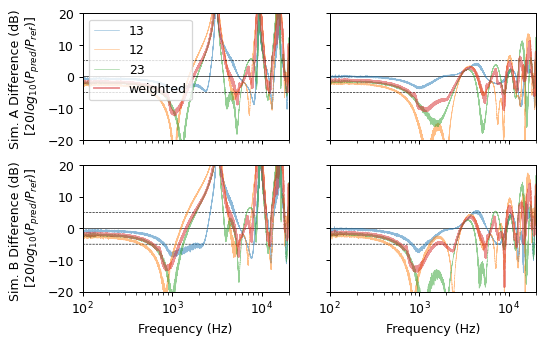

In [63]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)

axs[0, 0].semilogx(f_ref[0, trial], 20 * np.log10(pA13_pred_closer / p_ref[simA, trial]), 'C0', alpha=0.5, lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], 20 * np.log10(pA12_pred_closer / p_ref[simA, trial]), 'C1', alpha=0.5, lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], 20 * np.log10(pA23_pred_closer / p_ref[simA, trial]), 'C2', alpha=0.5, lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], 20 * np.log10(pA_pred_closer_weighted / p_ref[simA, trial]), 'C3', alpha=0.5)
axs[0, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[0, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)

axs[0, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], 20 * np.log10(pA13_pred_further / p_ref[simA + 1, trial]), 'C0', alpha=0.5, lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], 20 * np.log10(pA12_pred_further / p_ref[simA + 1, trial]), 'C1', alpha=0.5, lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], 20 * np.log10(pA23_pred_further / p_ref[simA + 1, trial]), 'C2', alpha=0.5, lw=0.5)
axs[0, 1].semilogx(f_ref[0, trial], 20 * np.log10(pA_pred_further_weighted / p_ref[simA + 1, trial]), 'C3', alpha=0.5)

axs[1, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], 20 * np.log10(pB13_pred_closer / p_ref[simB * 2, trial]), 'C0', alpha=0.5, lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], 20 * np.log10(pB12_pred_closer / p_ref[simB * 2, trial]), 'C1', alpha=0.5, lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], 20 * np.log10(pB23_pred_closer / p_ref[simB * 2, trial]), 'C2', alpha=0.5, lw=0.5)
axs[1, 0].semilogx(f_ref[0, trial], 20 * np.log10(pB_pred_closer_weighted / p_ref[simB * 2, trial]), 'C3', alpha=0.5)

axs[1, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0, 'k', lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 + 5, 'k--', lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], f_ref[0, trial] * 0 - 5, 'k--', lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], 20 * np.log10(pB13_pred_further / p_ref[simB * 2 + 1, trial]), 'C0', alpha=0.5, lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], 20 * np.log10(pB12_pred_further / p_ref[simB * 2 + 1, trial]), 'C1', alpha=0.5, lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], 20 * np.log10(pB23_pred_further / p_ref[simB * 2 + 1, trial]), 'C2', alpha=0.5, lw=0.5)
axs[1, 1].semilogx(f_ref[0, trial], 20 * np.log10(pB_pred_further_weighted / p_ref[simB * 2 + 1, trial]), 'C3', alpha=0.5)

axs[0, 0].legend(["13", "12", "23", "weighted"])
axs[0, 0].set_ylim(-20, 20)
axs[0, 0].set_xlim(100, 20000)
axs[1, 0].set_xlabel("Frequency (Hz)")
axs[1, 1].set_xlabel("Frequency (Hz)")
axs[0, 0].set_ylabel('Sim. A Difference (dB) \n [$20log_{10}(P_{pred} / P_{ref})$]')
axs[1, 0].set_ylabel('Sim. B Difference (dB) \n [$20log_{10}(P_{pred} / P_{ref})$]')